In [1]:
! pip install transformers
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
from google.colab import drive
drive.mount('/content/drive')
GOOGLE_DIR="/content/drive/MyDrive/Data"
LOCAL_DIR="/scratch/t.tovi/datasets"

# # # Download the datasets
# # !wget --directory-prefix=$DIR http://images.cocodataset.org/zips/train2017.zip
# # !wget --directory-prefix=$DIR http://images.cocodataset.org/zips/val2017.zip
# # !wget --directory-prefix=$DIR http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuffthingmaps_trainval2017.zip

#Unpack the datasets
!mkdir -p {LOCAL_DIR}/COCO_stuff_images
!mkdir -p {LOCAL_DIR}/COCO_stuff_annotations

# #!cp {GOOGLE_DIR}/train2017.zip {LOCAL_DIR}/COCO_stuff_images/
!cp {GOOGLE_DIR}/val2017.zip {LOCAL_DIR}/COCO_stuff_images/
!cp {GOOGLE_DIR}/stuffthingmaps_trainval2017.zip {LOCAL_DIR}/COCO_stuff_annotations/

# #!unzip {LOCAL_DIR}/COCO_stuff_images/train2017.zip -d {LOCAL_DIR}/COCO_stuff_images/
!unzip {LOCAL_DIR}/COCO_stuff_images/val2017.zip -d {LOCAL_DIR}/COCO_stuff_images/
!unzip {LOCAL_DIR}/COCO_stuff_annotations/stuffthingmaps_trainval2017.zip -d {LOCAL_DIR}/COCO_stuff_annotations/

Streaming output truncated to the last 5000 lines.
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000222235.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000038678.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000189698.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000208363.png  
 extracting: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000572956.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000384513.png  
 extracting: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000471893.png  
 extracting: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000302536.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000531036.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000087038.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/

In [3]:
import torch
from torch import nn
from transformers import CLIPProcessor, CLIPModel, CLIPTextModelWithProjection, CLIPVisionModelWithProjection
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import tqdm


In [4]:
class CLIPLang_prefix(nn.Module):

    '''
    This class is for detecting most salient object
    in the scene as an auto-regressive task
    '''

    def __init__(self, nhead=4, nencoder=4, clip_version="openai/clip-vit-base-patch16"):
        super().__init__()

        vision_model = CLIPVisionModelWithProjection.from_pretrained(clip_version)
        text_model = CLIPTextModelWithProjection.from_pretrained(clip_version)

        # vision model
        self.vision_encoder = vision_model.vision_model
        self.vision_projector = vision_model.visual_projection

        #text model
        self.text_model = text_model.text_model
        self.text_projector = text_model.text_projection

        # internal dimensions
        self.d_text = self.text_model.embeddings.token_embedding.weight.shape[1]
        self.d_image = self.vision_encoder.embeddings.position_embedding.weight.shape[1]

        # Learnable embeddings
        self.query_embeddings = nn.Embedding(20, self.d_text)
        self.query_embeddings.weight.data.normal_(mean=0, std=0.02)

        # transformer for next label prediction
        encoder_layers = nn.TransformerEncoderLayer(
            d_model = self.d_text,
            nhead = nhead,
            activation = nn.GELU(),
            batch_first = True
        )
        self.decoder = nn.TransformerEncoder(encoder_layers, num_layers=nencoder)

        # Projection
        self.label_head = nn.Linear(self.d_text, self.d_text)

        self.EOS_EMBEDDING = self.text_model.embeddings(torch.tensor([49407]))[0, 0, :]

    def sum_batch_entity_embeddings(self, batch_embeddings, batch_labels):
        output_seq_length = torch.max(batch_labels+1)
        summed_embeddings = torch.zeros((
            batch_embeddings.shape[0],
            output_seq_length,
            batch_embeddings.shape[-1]
        )).to(batch_embeddings.device)
        for i in range(batch_embeddings.shape[0]):
            for j in range(batch_embeddings.shape[1]):
                summed_embeddings[i, batch_labels[i, j]] += batch_embeddings[i, j]

            for k in range(torch.max(batch_labels[i]), output_seq_length):
                assert torch.zeros((1,2)).sum() == 0, "Error in summing embeddings"
                summed_embeddings[i, k] += self.EOS_EMBEDDING.to(batch_embeddings.device)
        summed_embeddings = summed_embeddings.detach()
        return summed_embeddings

    def to_embedding(self, input_ids):
        # index -> text_embeddings
        return self.text_model.embeddings(input_ids)

    def position_encode(self, embeddings):
        index_tensor = torch.arange(embeddings.shape[1]).repeat(embeddings.shape[0], 1).to(embeddings.device)
        return embeddings + self.text_model.embeddings.position_embedding(index_tensor)

    def visual_forward(self, pixel_values, output_hidden_states=False):
        # image -> text_embeddings
        return self.vision_encoder(pixel_values, output_hidden_states=output_hidden_states)

    def text_forward(self, text_embeddings):
        # text_embedding -> text_embeddings
        return self.text_model.encoder(text_embeddings)

    def decoder_forward(self, img_src, txt_tgt):
        # Send image seq and text seq to lang model
        # Concatenate prefix and visual embeddings
        decoder_input = torch.cat((txt_tgt, img_src), dim=1)
        # Return only the query tokens
        return self.decoder(decoder_input)[:, :txt_tgt.shape[1], :]

    def cond_forward(self, pixel_values, output_hidden_states = False):
        # Get visual features
        visual_outputs = self.visual_forward(pixel_values, output_hidden_states=output_hidden_states)
        visual_features = self.vision_projector(visual_outputs.last_hidden_state)

        # Get text embeddings
        # text_outputs = self.text_model.encoder(embeddings).last_hidden_state
        # text_features = self.text_projector(text_outputs)

        # Remove the [cls] token
        visual_features = visual_features[:, 1:, :]

        # Initialize query tokens
        index_tensor = torch.arange(20).repeat(pixel_values.shape[0], 1).to(pixel_values.device)
        query_tokens = self.query_embeddings(index_tensor)
        query_tokens = self.position_encode(query_tokens)

        # Decode texts
        text_pred = self.decoder_forward(visual_features, query_tokens)

        # Return both text embeddings and visual activations
        if output_hidden_states:
            return text_pred, [visual_outputs.hidden_states[i] for i in (3, 6, 9)]

        # Get text embeddings
        return text_pred

    def forward(self, pixel_values, output_hidden_states = False):

        if output_hidden_states:
            text_pred, hidden_states = self.cond_forward(pixel_values, output_hidden_states=output_hidden_states)
            return self.label_head(text_pred), hidden_states

        return self.label_head(self.cond_forward(pixel_values, embeddings))

class AutoSeg(nn.Module):
    def __init__(self, d_reduce=64, nhead=4, nencoder=4, ndecoder=4):
        super().__init__()

        self.encoders = CLIPLang_prefix(nhead=nhead, nencoder=nencoder+ndecoder)
        self.reduces = nn.ModuleList([
            nn.Linear(self.encoders.d_image, d_reduce) for _ in range(3)
        ])
        self.film_mul = nn.Linear(self.encoders.d_text, d_reduce)
        self.film_add = nn.Linear(self.encoders.d_text, d_reduce)

        self.decoder = nn.ModuleList([
            nn.TransformerEncoder(
                nn.TransformerEncoderLayer(
                    d_model=d_reduce,
                    nhead=nhead,
                    dim_feedforward=2048,
                    dropout=0.1,
                    activation=nn.GELU(),
                    batch_first=True,
                ),
                num_layers=1,
            )
            for _ in range(3)
        ])

        self.mask_head = nn.Sequential(
            nn.Conv2d(d_reduce, d_reduce, kernel_size=(3, 3), padding=(1, 1), padding_mode="replicate"),
            nn.GELU(),
            nn.ConvTranspose2d(d_reduce, d_reduce//2, kernel_size=(4, 4), stride=(4, 4)),
            nn.GELU(),
            nn.ConvTranspose2d(d_reduce//2, 1, kernel_size=(4, 4), stride=(4, 4))
        )

    def forward(self, pixel_values):
        # Get text embeddings
        lang_output, hidden_states = self.encoders.cond_forward(pixel_values, output_hidden_states=True)

        # Image sequence size
        self.image_seq_size = int(np.sqrt(hidden_states[0].shape[1]))

        masks = []
        for i, batch_embeddings in enumerate(lang_output.permute(1, 0, 2)):
            a  = None
            for hs, block, reduce in zip(hidden_states, self.decoder, self.reduces):
                hs = hs.permute(1, 0, 2)
                if a is None:
                    a = reduce(hs)
                else:
                    a = a + reduce(hs)

                a = a * self.film_mul(batch_embeddings) + self.film_add(batch_embeddings)
                a = block(a)

            a = a[1:].permute(1, 2, 0)
            a = a.view(a.shape[0], a.shape[1], self.image_seq_size, self.image_seq_size)
            a = self.mask_head(a)
            masks.append(a)

        masks = torch.cat(masks, dim=1)
        return masks, lang_output

In [5]:
src_dir = "./"
dataset_dir = "/scratch/t.tovi/datasets/"
image_dir = "COCO_stuff_images/val2017/"
annotation_dir = "COCO_stuff_annotations/val2017/"

class COCOStuffDatasetEval(Dataset):
    def __init__(self, image_dir, annotation_dir, img_size=224):
        """
        Args:
            image_dir (string): Directory with all the images.
            annotation_dir (string): Directory with all the annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.images = os.listdir(image_dir)
        self.img_size = img_size

        self.selected_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48,
                                49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]

        # Load the label mapping
        self.digit_to_object_mapping = {}
        with open(f'{src_dir}labels.txt', 'r') as file:
            for line in file:
                key, value = line.strip().split(':')
                self.digit_to_object_mapping[int(key)] = value.strip()
        self.digit_to_object_mapping[255] = "unlabled"

    def center_crop(self, image, mask):
        transform = transforms.CenterCrop(self.img_size)
        return transform(image), transform(mask)

    def resize(self, image, mask):
        transform = transforms.CenterCrop(min(image.size))

        cropped_image = transform(image)
        cropped_mask = transform(mask)

        resized_image = transforms.Resize((self.img_size, self.img_size),transforms.InterpolationMode.BILINEAR)(cropped_image)
        resized_mask= transforms.Resize((self.img_size, self.img_size), transforms.InterpolationMode.NEAREST)(cropped_mask)
        return resized_image, resized_mask

    def __len__(self):
        return len(self.images)

    def get(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name)#.convert('RGB')

        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.png'))
        annotation = Image.open(annotation_name)

        ids = np.unique(np.array(annotation))
        ids = [id for id in ids if id in self.selected_labels]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        return image, annotation, labels

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        # Load annotation
        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.png'))
        annotation = Image.open(annotation_name)

        image, mask = self.resize(image, annotation)
        mask = np.array(mask)
        mask += 1
        mask[mask==256] = 0


        # Indexed masks
        ids = np.unique(mask)
        #ids = [id for id in ids if id in self.selected_labels]
        nonempty_masks = [np.full(mask.shape, id) * (mask==id) for id in ids]
        nonempty_masks = sorted(nonempty_masks, key=lambda x: np.sum(x!=0), reverse=True)

        # Get ids and labels
        ids = [np.unique(mask)[-1] for mask in nonempty_masks]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        # Convert to binary masks
        nonempty_masks = [(mask != 0).astype(float) for mask in nonempty_masks]

        sample = {'image': image, 'annotation': nonempty_masks, 'labels': labels, 'ids': ids}

        return sample

In [6]:
def collate_fn_factory(processor, max_size=20):

    def collate_fn(batch):
        size = processor.image_processor.size['shortest_edge'] #224
        transform = transforms.ToTensor()

        # Preprocess pixel values
        images = [each['image'] for each in batch]
        batch_pixel_values = processor(None, images=images, return_tensors='pt')['pixel_values']

        # Preprocess labels
        ids = torch.full((len(batch), max_size), 0)
        ids[:, :max_size] = torch.tensor([each['ids'][:max_size] + [0] * (max_size - len(each['ids'])) for each in batch])

        # Preprocess masks
        batch_masks = np.stack([
            np.stack(each['annotation'][:max_size] + [np.zeros((size, size))] * (max_size - len(each['annotation'])) )
            for each in batch
        ])
        batch_masks = torch.tensor(batch_masks[:, :max_size])

        return {
            "pixel_values": batch_pixel_values,
            "masks": batch_masks.type(torch.float32),
            "ids": ids.type(torch.long)
        }

    return collate_fn

In [7]:
import math

def mean_iou(y_true, y_pred, classes):
    """
    Compute the Intersection over Union (IoU) for each class in the list.

    Parameters:
    y_true (np.array): The ground truth labels.
    y_pred (np.array): The predicted labels.
    classes (list): A list of class IDs to compute IoU for.

    Returns:
    np.array: An array of IoUs for each class in the list.
    """
    iou_list = []
    for class_id in classes:
        true_positive = torch.sum((y_true == class_id) & (y_pred == class_id))
        false_positive = torch.sum((y_true != class_id) & (y_pred == class_id))
        false_negative = torch.sum((y_true == class_id) & (y_pred != class_id))
        union = true_positive + false_positive + false_negative

        if union == 0:
            iou = 1.0  # Perfect match or no data for the class
        else:
            iou = true_positive / union

        if torch.isnan(iou):
            iou = 0.0

        iou_list.append(iou.detach().cpu().item())
    return np.mean(iou_list)

In [8]:
! cp drive/MyDrive/Data/autoseg_v0.4 ./

In [9]:
model = AutoSeg(d_reduce=128)
model.load_state_dict(torch.load('autoseg_v0.4'))
model = model.to(0)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [ ]:
device = 0

# Define dataset dir
dataset_dir = "/scratch/t.tovi/datasets/"

# Create dataset object
data = COCOStuffDatasetEval(
    dataset_dir+"COCO_stuff_images/val2017",
    dataset_dir+"COCO_stuff_annotations/val2017",
    img_size=224
)

lang_model = CLIPLang_prefix()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [ ]:
# Get loss query table

labels = data.digit_to_object_mapping
label_indices = list(data.digit_to_object_mapping.keys())
label_text = ["a photo of " + data.digit_to_object_mapping[each] for each in label_indices]
label_indices = processor(label_text, padding=True, return_tensors='pt')['input_ids']

with torch.no_grad():
    label_embeddings = lang_model.text_model(label_indices)["pooler_output"]
    eos_embedding = lang_model.text_model(torch.tensor([processor.tokenizer.eos_token_id]))["pooler_output"]
    bos_embedding = lang_model.text_model(torch.tensor([processor.tokenizer.bos_token_id]))["pooler_output"]

    label_embeddings = lang_model.text_projector(label_embeddings)
    eos_embedding = lang_model.text_projector(eos_embedding)
    bos_embedding = lang_model.text_projector(bos_embedding)

label_embeddings.requires_grad_(False)
eos_embedding.requires_grad_(False)
bos_embedding.requires_grad_(False)

reverse_mapping = {v: k for k, v in data.digit_to_object_mapping.items()}

In [ ]:
# Get the collate function
collate_fn = collate_fn_factory(processor)

# Create batch data loader
data_loader = DataLoader(data, batch_size=1, collate_fn=collate_fn, num_workers=0, shuffle=True)

m = nn.Sigmoid()
temperature = 0.02
label_embeddings = label_embeddings.to(0)
label_embeddings = F.normalize(label_embeddings, dim=-1)

In [ ]:
all_miou = []
for batch in tqdm.tqdm(data_loader):
    pixel_values = batch['pixel_values'].to(device)
    masks = batch['masks'].to(device)
    ids = batch['ids'].to(device)

    mask_logits, pred_embeddings = model(pixel_values)

    ids = batch['ids'].squeeze(0)
    ids = ids[ids != 0]
    ground_truth_embeddings = label_embeddings[ids]
    predicted_embeddings = F.normalize(pred_embeddings, dim=-1).squeeze(0)
    correspondence = torch.argmax(ground_truth_embeddings @ predicted_embeddings.T, dim=-1)

    predicted_masks = (m(mask_logits[0, correspondence])> 0.3).int() #, correspoondence
    for i in range(len(ids)):
        predicted_masks[i] = predicted_masks[i] * ids[i]

    ground_truth_masks = masks.squeeze(0)[: len(ids)]
    for i in range(len(ids)):
        ground_truth_masks[i] = ground_truth_masks[i] * ids[i]

    score = mean_iou(ground_truth_masks, predicted_masks, ids)
    all_miou.append(score)

    break

    if len(all_miou) % 100 == 0:
        print(np.nanmean(all_miou))


  0%|          | 0/5000 [00:00<?, ?it/s]


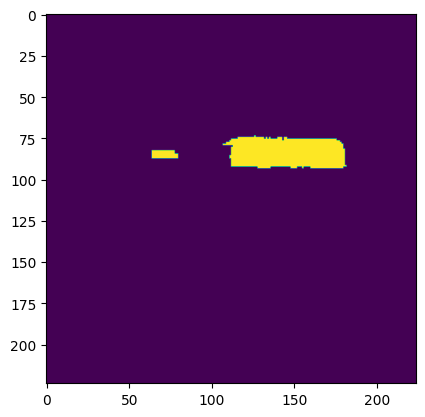

In [ ]:
plt.imshow(m(mask_logits[0, 4]).detach().cpu().numpy() > 0.3)

0.34009452966543346

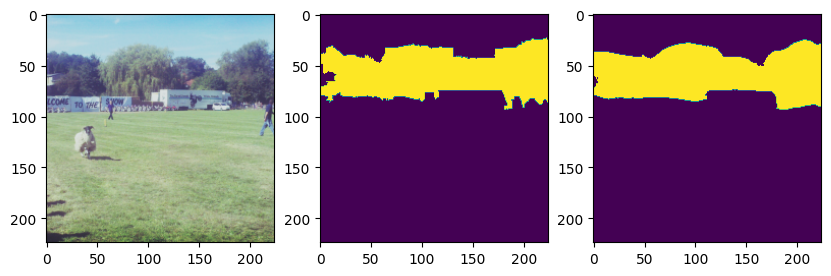

In [ ]:
i = 1

fig, axs = plt.subplots(1, 3, figsize=(10, 30))
axs[0].imshow(m(pixel_values[0]).permute(1, 2, 0).cpu().numpy())
axs[1].imshow(ground_truth_masks[i].cpu().numpy())
axs[2].imshow(predicted_masks[i].cpu().numpy())

mean_iou(ground_truth_masks, predicted_masks, ids)

(-0.5, 223.5, 223.5, -0.5)

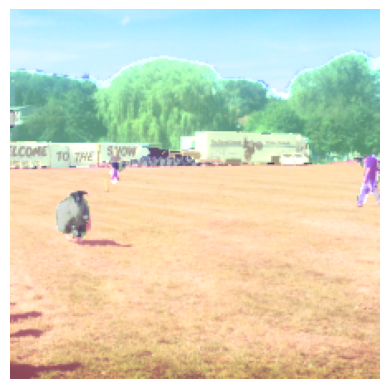

In [ ]:
def overlay(mask, color=np.array([0.3, 0.1, 0.1]).reshape(3, 1, 1)):
    mask = mask.cpu().repeat(3, 1, 1).float()
    mask = mask / mask.max()
    mask *= color
    mask = np.transpose(mask, (1, 2, 0))
    return mask.numpy()

img = m(pixel_values[0]).cpu().numpy()
img = img.transpose((1, 2 ,0))

colors = [
    np.array([0.3, 0.1, 0.1]).reshape(3, 1, 1) *1.2,
    np.array([0.1, 0.3, 0.1]).reshape(3, 1, 1) *1.2,
    np.array([0.1, 0.1, 0.3]).reshape(3, 1, 1) *1.2,
    np.array([0.3, 0.3, 0.1]).reshape(3, 1, 1) *1.2,
    np.array([0.3, 0.1, 0.3]).reshape(3, 1, 1) *1.2,
    np.array([0.1, 0.3, 0.3]).reshape(3, 1, 1) *1.2,
    np.array([0.3, 0.3, 0.3]).reshape(3, 1, 1) *1.2,
]
#masks = [m(mask_logit) > 0.3 for mask_logit in mask_logits.cpu()]

for i, mask in enumerate(predicted_masks[:5]):
    img += overlay(mask, color=colors[i])

plt.imshow(img)
plt.axis('off')

## Pascal VOC Eval

In [21]:
#Unpack the datasets
#!mkdir -p {LOCAL_DIR}/VOCdevkit

!cp {GOOGLE_DIR}/VOCtrainval_11-May-2012.tar {LOCAL_DIR}

!tar -xvf {GOOGLE_DIR}/VOCtrainval_11-May-2012.tar -C {LOCAL_DIR}

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

In [22]:
src_dir = "./"
dataset_dir = "/scratch/t.tovi/datasets/"
image_dir = "VOCdevkit/VOCdevkit/VOC2012/JPEGImages/"
annotation_dir = "VOCdevkit/VOCdevkit/VOC2012/SegmentationClass/"
val_ids = "VOCdevkit/VOCdevkit/VOC2012/ImageSets/Main/val.txt"

class PascalDatasetEval(Dataset):
    def __init__(self, val_ids_file, image_dir, annotation_dir, img_size=224):
        """
        Args:
            image_dir (string): Directory with all the images.
            annotation_dir (string): Directory with all the annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = []
        with open(val_ids_file, 'r') as file:
            for line in file:
                id = line.strip() + ".jpg"
                self.images.append(id)

        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.img_size = img_size

        # Load the label mapping
        self.digit_to_object_mapping = {}
        with open(f'{src_dir}test_labels.txt', 'r') as file:
            for line in file:
                key, value = line.strip().split(':')
                self.digit_to_object_mapping[int(key)] = value.strip()
        self.digit_to_object_mapping[255] = "unlabled"

    def center_crop(self, image, mask):
        transform = transforms.CenterCrop(self.img_size)
        return transform(image), transform(mask)

    def resize(self, image, mask):
        transform = transforms.CenterCrop(min(image.size))

        cropped_image = transform(image)
        cropped_mask = transform(mask)

        resized_image = transforms.Resize((self.img_size, self.img_size),transforms.InterpolationMode.BILINEAR)(cropped_image)
        resized_mask= transforms.Resize((self.img_size, self.img_size), transforms.InterpolationMode.NEAREST)(cropped_mask)
        return resized_image, resized_mask

    def __len__(self):
        return len(self.images)

    def get(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name)#.convert('RGB')

        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.png'))
        annotation = Image.open(annotation_name)

        ids = np.unique(np.array(annotation))
        labels = [self.digit_to_object_mapping[id] for id in ids]

        return image, annotation, labels

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name)#.convert('RGB')

        # Load annotation
        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.png'))
        annotation = Image.open(annotation_name)

        image, mask = self.resize(image, annotation)
        mask = np.array(mask)
        #mask += 1
        mask[mask==255] = 0


        # Indexed masks
        ids = np.unique(mask)
        ids = [id for id in ids if id != 0]
        nonempty_masks = [np.full(mask.shape, id) * (mask==id) for id in ids]
        nonempty_masks = sorted(nonempty_masks, key=lambda x: np.sum(x!=0), reverse=True)

        # Get ids and labels
        ids = [np.unique(mask)[-1] for mask in nonempty_masks]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        # Convert to binary masks
        nonempty_masks = [(mask != 0).astype(float) for mask in nonempty_masks]

        sample = {'image': image, 'annotation': nonempty_masks, 'labels': labels, 'ids': ids}

        return sample

In [23]:
device = 0

src_dir = "./"
dataset_dir = "/scratch/t.tovi/datasets/"
image_dir = "VOCdevkit/VOC2012/JPEGImages/"
annotation_dir = "VOCdevkit/VOC2012/SegmentationClass/"
val_ids = "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"

# Define dataset dir
dataset_dir = "/scratch/t.tovi/datasets/"

# Create dataset object
data = PascalDatasetEval(
    dataset_dir+val_ids,
    dataset_dir+image_dir,
    dataset_dir+annotation_dir,
    img_size=224
)

lang_model = CLIPLang_prefix()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

FileNotFoundError: [Errno 2] No such file or directory: './test_labels.txt'

In [ ]:
# Get loss query table

labels = data.digit_to_object_mapping
label_indices = list(data.digit_to_object_mapping.keys())
label_text = ["a photo of " + data.digit_to_object_mapping[each] for each in label_indices]
label_indices = processor(label_text, padding=True, return_tensors='pt')['input_ids']

with torch.no_grad():
    label_embeddings = lang_model.text_model(label_indices)["pooler_output"]
    eos_embedding = lang_model.text_model(torch.tensor([processor.tokenizer.eos_token_id]))["pooler_output"]
    bos_embedding = lang_model.text_model(torch.tensor([processor.tokenizer.bos_token_id]))["pooler_output"]

    label_embeddings = lang_model.text_projector(label_embeddings)
    eos_embedding = lang_model.text_projector(eos_embedding)
    bos_embedding = lang_model.text_projector(bos_embedding)

label_embeddings.requires_grad_(False)
eos_embedding.requires_grad_(False)
bos_embedding.requires_grad_(False)

reverse_mapping = {v: k for k, v in data.digit_to_object_mapping.items()}

In [ ]:
# Get the collate function
collate_fn = collate_fn_factory(processor)

# Create batch data loader
data_loader = DataLoader(data, batch_size=1, collate_fn=collate_fn, num_workers=2, shuffle=True)

m = nn.Sigmoid()
temperature = 0.02
label_embeddings = label_embeddings.to(0)
label_embeddings = F.normalize(label_embeddings, dim=-1)

In [ ]:
all_miou = []
for batch in tqdm.tqdm(data_loader):
    pixel_values = batch['pixel_values'].to(device)
    masks = batch['masks'].to(device)
    ids = batch['ids'].to(device)

    mask_logits, pred_embeddings = model(pixel_values)

    ids = batch['ids'].squeeze(0)
    ids = ids[ids != 0]
    ground_truth_embeddings = label_embeddings[ids]
    predicted_embeddings = F.normalize(pred_embeddings, dim=-1).squeeze(0)
    correspondence = torch.argmax(ground_truth_embeddings @ predicted_embeddings.T, dim=-1)

    predicted_masks = (m(mask_logits[0, correspondence]) > 0.2).int()
    for i in range(len(ids)):
        predicted_masks[i] = predicted_masks[i] * ids[i]

    ground_truth_masks = masks.squeeze(0)[: len(ids)]
    for i in range(len(ids)):
        ground_truth_masks[i] = ground_truth_masks[i] * ids[i]

    score = mean_iou(ground_truth_masks, predicted_masks, ids)
    all_miou.append(score)

    #break

    if len(all_miou) % 100 == 0:
        print(np.nanmean(all_miou))

  0%|          | 0/1449 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  7%|▋         | 101/1449 [00:13<02:39,  8.48it/s]

0.6041328280069865


 14%|█▍        | 201/1449 [00:25<02:25,  8.58it/s]

0.6184430203065858


 21%|██        | 301/1449 [00:38<02:48,  6.82it/s]

0.6426673025513042


 28%|██▊       | 401/1449 [00:51<03:04,  5.68it/s]

0.6448745042156951


 35%|███▍      | 501/1449 [01:04<02:26,  6.46it/s]

0.6524399894880675


 41%|████▏     | 601/1449 [01:17<02:08,  6.60it/s]

0.6552415548219385


 48%|████▊     | 701/1449 [01:30<01:50,  6.80it/s]

0.6538896382104576


 55%|█████▌    | 801/1449 [01:42<01:16,  8.52it/s]

0.6571462610923428


 62%|██████▏   | 901/1449 [01:55<01:00,  8.99it/s]

0.660932993276926


 69%|██████▉   | 1001/1449 [02:08<00:51,  8.68it/s]

0.6581582167575306


 76%|███████▌  | 1101/1449 [02:21<00:41,  8.39it/s]

0.6586871021729238


 79%|███████▊  | 1141/1449 [02:26<00:50,  6.13it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 83%|████████▎ | 1201/1449 [02:34<00:29,  8.50it/s]

0.6580084049406097


 90%|████████▉ | 1301/1449 [02:46<00:17,  8.63it/s]

0.6557599453833529


 97%|█████████▋| 1401/1449 [02:59<00:06,  7.88it/s]

0.6553309522283103


100%|██████████| 1449/1449 [03:05<00:00,  7.82it/s]


0.2978547957415382

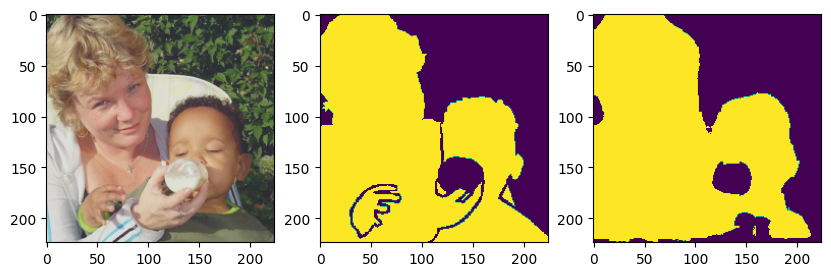

In [ ]:
i = 0

fig, axs = plt.subplots(1, 3, figsize=(10, 30))
axs[0].imshow(m(pixel_values[0]).permute(1, 2, 0).cpu().numpy())
axs[1].imshow(ground_truth_masks[i].cpu().numpy())
axs[2].imshow(predicted_masks[i].cpu().numpy())

mean_iou(ground_truth_masks, predicted_masks, ids)

# Pascal Context

In [14]:
! cp {GOOGLE_DIR}/trainval.tar.gz {LOCAL_DIR}
! cp {GOOGLE_DIR}/VOCtrainval_03-May-2010.tar {LOCAL_DIR}

! tar -xvf {GOOGLE_DIR}/trainval.tar.gz -C {LOCAL_DIR}
! tar -xvf {GOOGLE_DIR}/VOCtrainval_03-May-2010.tar -C {LOCAL_DIR}

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2010/JPEGImages/2010_004750.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004751.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004753.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004756.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004757.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004760.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004763.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004765.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004766.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004768.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004770.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004772.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004773.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004775.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004777.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004778.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004779.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004782.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004783.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004785.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004786.jpg
VOCd

In [24]:
from scipy.io import loadmat

class PascalContextEval(Dataset):
    def __init__(self, val_ids_file, image_dir, annotation_dir, img_size=224):
        """
        Args:
            image_dir (string): Directory with all the images.
            annotation_dir (string): Directory with all the annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = []
        with open(val_ids_file, 'r') as file:
            for line in file:
                id = line.strip() + ".jpg"
                self.images.append(id)

        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.img_size = img_size

        # Load the label mapping
        self.digit_to_object_mapping = {}
        with open('/scratch/t.tovi/datasets/labels.txt', 'r') as file:
            for line in file:
                key, value = line.strip().split(':')
                self.digit_to_object_mapping[int(key)] = value.strip()

        # self.selected_labels = [
        #     0, 2, 259, 260, 415, 324, 9, 258, 144, 18, 19, 22,
        #     23, 397, 25, 284, 158, 159, 416, 33, 162, 420, 454, 295, 296,
        #     427, 44, 45, 46, 308, 59, 440, 445, 31, 232, 65, 354, 424,
        #     68, 326, 72, 458, 34, 207, 80, 355, 85, 347, 220, 349, 360,
        #     98, 187, 104, 105, 366, 189, 368, 113, 115]

        self.selected_labels = list(self.digit_to_object_mapping.keys())

    def center_crop(self, image, mask):
        transform = transforms.CenterCrop(self.img_size)
        return transform(image), transform(mask)

    def resize(self, image, mask):
        transform = transforms.CenterCrop(min(image.size))

        cropped_image = transform(image)
        cropped_mask = transform(mask)

        resized_image = transforms.Resize((self.img_size, self.img_size),transforms.InterpolationMode.BILINEAR)(cropped_image)
        resized_mask= transforms.Resize((self.img_size, self.img_size), transforms.InterpolationMode.NEAREST)(cropped_mask)
        return resized_image, resized_mask

    def __len__(self):
        return len(self.images)

    def get(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.mat'))
        annotation = loadmat(annotation_name)['LabelMap']
        annotation = Image.fromarray(annotation)

        ids = np.unique(np.array(annotation))
        ids = [id for id in ids if id in self.selected_labels]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        return image, annotation, labels

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        # Load annotation
        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.mat'))
        annotation = loadmat(annotation_name)['LabelMap']
        annotation = Image.fromarray(annotation)

        image, mask = self.resize(image, annotation)
        mask = np.array(mask)

        # Indexed masks
        ids = np.unique(mask)
        ids = [id for id in ids if id in self.selected_labels]
        nonempty_masks = [np.full(mask.shape, id) * (mask==id) for id in ids]
        nonempty_masks = sorted(nonempty_masks, key=lambda x: np.sum(x!=0), reverse=True)

        # Get ids and labels
        ids = [np.unique(mask)[-1] for mask in nonempty_masks]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        # Convert to binary masks
        nonempty_masks = [(mask != 0).astype(float) for mask in nonempty_masks]
        ids = [int(id) for id in ids]
        sample = {'image': image, 'annotation': nonempty_masks, 'labels': labels, 'ids': ids}

        return sample

In [27]:
device = 0

src_dir = "./"
dataset_dir = "/scratch/t.tovi/datasets/"
image_dir = "VOCdevkit/VOC2010/JPEGImages/"
annotation_dir = "trainval/"
val_ids = "VOCdevkit/VOC2010/ImageSets/Main/val.txt"

# Create dataset object
data = PascalContextEval(
    dataset_dir+val_ids,
    dataset_dir+image_dir,
    dataset_dir+annotation_dir,
    img_size=224
)

lang_model = CLIPLang_prefix()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [28]:
# Get loss query table

labels = data.digit_to_object_mapping
label_indices = list(labels.keys())
label_text = ["a photo of unlabled"] + ["a photo of " + labels[each] for each in label_indices]
label_indices = processor(label_text, padding=True, return_tensors='pt')['input_ids']

with torch.no_grad():
    label_embeddings = lang_model.text_model(label_indices)["pooler_output"]
    eos_embedding = lang_model.text_model(torch.tensor([processor.tokenizer.eos_token_id]))["pooler_output"]
    bos_embedding = lang_model.text_model(torch.tensor([processor.tokenizer.bos_token_id]))["pooler_output"]

    label_embeddings = lang_model.text_projector(label_embeddings)
    eos_embedding = lang_model.text_projector(eos_embedding)
    bos_embedding = lang_model.text_projector(bos_embedding)

label_embeddings.requires_grad_(False)
eos_embedding.requires_grad_(False)
bos_embedding.requires_grad_(False)

reverse_mapping = {v: k for k, v in data.digit_to_object_mapping.items()}

In [29]:
# Get the collate function
collate_fn = collate_fn_factory(processor)

# Create batch data loader
data_loader = DataLoader(data, batch_size=1, collate_fn=collate_fn, num_workers=0, shuffle=True)

m = nn.Sigmoid()
label_embeddings = label_embeddings.to(0)
label_embeddings = F.normalize(label_embeddings, dim=-1)

In [30]:
all_miou = []
for batch in tqdm.tqdm(data_loader):
    pixel_values = batch['pixel_values'].to(device)
    masks = batch['masks'].to(device)
    ids = batch['ids'].to(device)

    mask_logits, pred_embeddings = model(pixel_values)

    ids = batch['ids'].squeeze(0)
    ids = ids[ids != 0]
    ground_truth_embeddings = label_embeddings[ids]
    predicted_embeddings = F.normalize(pred_embeddings, dim=-1).squeeze(0)
    correspondence = torch.argmax(ground_truth_embeddings @ predicted_embeddings.T, dim=-1)

    predicted_masks = (m(mask_logits[0, correspondence])> 0.3).int()
    for i in range(len(ids)):
        predicted_masks[i] = predicted_masks[i] * ids[i]

    ground_truth_masks = masks.squeeze(0)[: len(ids)]
    for i in range(len(ids)):
        ground_truth_masks[i] = ground_truth_masks[i] * ids[i]

    score = mean_iou(ground_truth_masks, predicted_masks, ids)
    all_miou.append(score)
    #break
    if len(all_miou) % 100 == 0:
        print(np.mean(all_miou))


  2%|▏         | 101/5105 [00:16<11:54,  7.01it/s]

0.4780377639554528


  4%|▍         | 201/5105 [00:31<13:32,  6.04it/s]

0.4710525863469509


  6%|▌         | 301/5105 [00:46<13:40,  5.86it/s]

0.45465592710728886


  8%|▊         | 401/5105 [00:59<10:48,  7.26it/s]

0.4516202095945019


 10%|▉         | 501/5105 [01:13<09:36,  7.98it/s]

0.4502429700287081


 12%|█▏        | 601/5105 [01:28<09:10,  8.18it/s]

0.44987815332039766


 14%|█▎        | 701/5105 [01:41<09:15,  7.94it/s]

0.4471613947539502


 16%|█▌        | 801/5105 [01:56<09:21,  7.66it/s]

0.45014747538491456


 18%|█▊        | 901/5105 [02:09<08:59,  7.79it/s]

0.4549282161433613


 20%|█▉        | 1001/5105 [02:23<08:46,  7.79it/s]

0.4575024252051426


 22%|██▏       | 1101/5105 [02:37<08:23,  7.95it/s]

0.45881605018057814


 24%|██▎       | 1201/5105 [02:51<08:45,  7.42it/s]

0.4581535945429592


 25%|██▌       | 1301/5105 [03:06<08:09,  7.78it/s]

0.4571581114875424


 27%|██▋       | 1401/5105 [03:20<07:46,  7.94it/s]

0.4565279830036427


 29%|██▉       | 1501/5105 [03:33<07:31,  7.99it/s]

0.4535644445766175


 31%|███▏      | 1601/5105 [03:47<07:30,  7.78it/s]

0.4544793066145826


 33%|███▎      | 1701/5105 [04:01<07:15,  7.82it/s]

0.4536067687583506


 35%|███▌      | 1801/5105 [04:15<06:47,  8.11it/s]

0.45459315518298177


 37%|███▋      | 1901/5105 [04:29<06:44,  7.92it/s]

0.45358533791069333


 39%|███▉      | 2001/5105 [04:43<06:32,  7.90it/s]

0.4545561703326821


 41%|████      | 2101/5105 [04:57<08:03,  6.21it/s]

0.45324678589880846


 43%|████▎     | 2201/5105 [05:11<08:29,  5.70it/s]

0.4539333356016595


 45%|████▌     | 2300/5105 [05:25<09:36,  4.87it/s]

0.4545106162754745


 47%|████▋     | 2401/5105 [05:40<07:35,  5.94it/s]

0.45407874328428344


 49%|████▉     | 2501/5105 [05:54<07:21,  5.90it/s]

0.45389824161061954


 51%|█████     | 2601/5105 [06:08<08:03,  5.18it/s]

0.45330182244110695


 53%|█████▎    | 2701/5105 [06:22<05:51,  6.84it/s]

0.4542325825143572


 55%|█████▍    | 2801/5105 [06:35<04:53,  7.84it/s]

0.4541403623785792


 57%|█████▋    | 2901/5105 [06:49<04:41,  7.84it/s]

0.45432350903175983


 59%|█████▉    | 3001/5105 [07:03<04:44,  7.38it/s]

0.45435373885305186


 61%|██████    | 3101/5105 [07:16<04:44,  7.04it/s]

0.4540970653946195


 63%|██████▎   | 3201/5105 [07:30<04:13,  7.52it/s]

0.45426058110473916


 65%|██████▍   | 3301/5105 [07:44<04:03,  7.39it/s]

0.45529883875017346


 67%|██████▋   | 3401/5105 [07:59<03:36,  7.88it/s]

0.45484187693931943


 69%|██████▊   | 3501/5105 [08:12<03:35,  7.46it/s]

0.4554750851260946


 71%|███████   | 3600/5105 [08:26<03:14,  7.76it/s]

0.45563456601471647


 72%|███████▏  | 3701/5105 [08:40<03:00,  7.78it/s]

0.4552976713455192


 74%|███████▍  | 3801/5105 [08:54<02:53,  7.52it/s]

0.45480591342598126


 76%|███████▋  | 3901/5105 [09:08<02:30,  8.00it/s]

0.4550455222729013


 78%|███████▊  | 4001/5105 [09:22<02:20,  7.85it/s]

0.45515702414401654


 80%|████████  | 4101/5105 [09:36<02:10,  7.66it/s]

0.4553900271856191


 82%|████████▏ | 4201/5105 [09:49<01:55,  7.84it/s]

0.4561722539514985


 84%|████████▍ | 4301/5105 [10:03<01:42,  7.83it/s]

0.45605178938977115


 86%|████████▌ | 4401/5105 [10:17<01:28,  7.95it/s]

0.4559937195401436


 88%|████████▊ | 4501/5105 [10:32<01:35,  6.30it/s]

0.45563030866659887


 90%|█████████ | 4601/5105 [10:46<01:27,  5.76it/s]

0.45520979759153535


 92%|█████████▏| 4701/5105 [11:00<01:08,  5.90it/s]

0.45564118123144143


 94%|█████████▍| 4801/5105 [11:14<00:53,  5.73it/s]

0.4550471022339888


 96%|█████████▌| 4901/5105 [11:28<00:34,  5.95it/s]

0.4545266678589585


 98%|█████████▊| 5001/5105 [11:42<00:14,  7.01it/s]

0.4549181809112335


100%|█████████▉| 5101/5105 [11:56<00:00,  7.68it/s]

0.4553820972157235


100%|██████████| 5105/5105 [11:56<00:00,  7.12it/s]


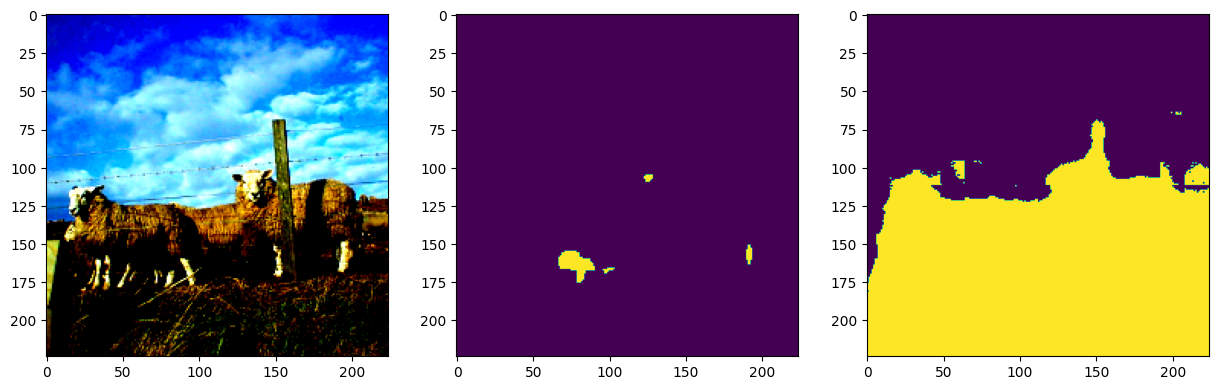

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

i = 7

axs[0].imshow(batch['pixel_values'][0].permute(1, 2, 0))
axs[1].imshow(batch['masks'][0][i].cpu().numpy())
axs[2].imshow(predicted_masks[i].cpu().numpy())